In [1]:
import pandas as pd
import numpy as no

data_df = pd.read_csv('house-prices.csv')

print("Shape:",data_df.shape)

data_df.head(2)

Shape: (2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000


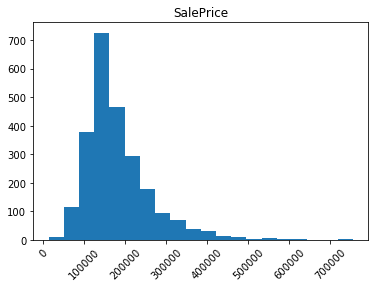

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

data_df.hist(column='SalePrice', bins=20, grid=False, xrot=45)
plt.show()

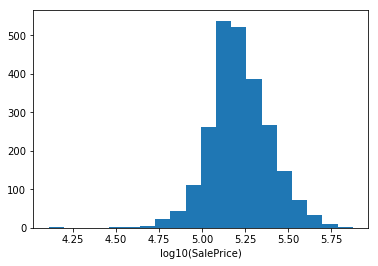

In [3]:
import numpy as np

plt.hist(np.log10(data_df.SalePrice), bins=20)
plt.xlabel('log10(SalePrice)')
plt.show()


In [4]:
def preprocess(df):
    # Work on a copy
    df = df.copy()

    # One-hot encoding
    df = pd.get_dummies(df, dummy_na=True)

    # Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(df[c].median())

    return df

preprocessed_df = preprocess(data_df)
preprocessed_df.head()


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_VWD,Sale Type_WD,Sale Type_nan,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Sale Condition_nan
0,484,528275070,60,68.0,8795,7,5,2000,2000,0.0,...,0,1,0,0,0,0,0,1,0,0
1,2586,535305120,20,75.0,10170,6,6,1951,1951,522.0,...,0,1,0,0,0,0,0,1,0,0
2,2289,923228250,160,21.0,2001,4,5,1970,1970,80.0,...,0,1,0,0,0,0,0,1,0,0
3,142,535152150,20,70.0,10552,5,5,1959,1959,0.0,...,0,1,0,0,0,0,0,1,0,0
4,2042,903475060,190,60.0,10120,7,4,1910,1950,0.0,...,0,1,0,0,0,0,0,1,0,0


In [5]:
# Build X/y variables
# Warning: Use the log10 value for SalePrice
X = preprocessed_df.drop('SalePrice', axis=1).values
y = np.log10(preprocessed_df['SalePrice'])


from sklearn.model_selection import train_test_split

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.5, random_state=0)

print('Train:', X_tr.shape, y_tr.shape) # (1215, 347) (1215,)
print('Test:', X_te.shape, y_te.shape) # (1215, 347) (1215,)


Train: (1215, 347) (1215,)
Test: (1215, 347) (1215,)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr)

print('Train MSE: {:.4f}'.format(MSE(y_tr, lr.predict(X_tr_rescaled))))
# Prints: 0.0014
print('Test MSE: {:.4f}'.format(MSE(y_te, lr.predict(X_te_rescaled))))
# Prints: 55088846474204635136.0000 (results can vary depending on your computer)


Train MSE: 0.0014
Test MSE: 3829628021697941078016.0000


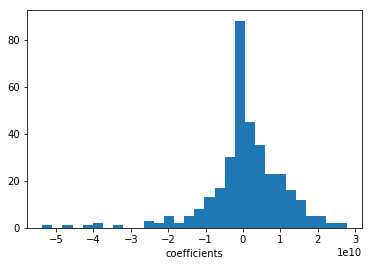

In [8]:
# Test MSE is extemely high, let's inspect coefficients found by LinearRegression
# with an histogram

plt.hist(lr.coef_, bins=30)
plt.xlabel('coefficients')
plt.show()

In [25]:
# Grid search of Ridge parameters
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE


# Store variables in an array
gs_results = []

for alpha in np.logspace(-10,10,num=100):
    # create and fit Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    gs_results.append({
        'alpha': alpha,
        'train_mae': MAE(10**y_tr,10**ridge.predict(X_tr_rescaled)),
        'train_mse': MSE(y_tr,ridge.predict(X_tr_rescaled)),
        'test_mae': MAE(10**y_te,10**ridge.predict(X_te_rescaled)),
        'test_mse': MSE(y_te,ridge.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,1.000000e-10,17817.978091,0.006008,11145.427596,0.001412
1,1.592283e-10,17815.947530,0.006008,11145.427596,0.001412
2,2.535364e-10,17816.958271,0.006008,11145.427596,0.001412
3,4.037017e-10,17816.486198,0.006007,11145.427596,0.001412
4,6.428073e-10,17816.858933,0.006007,11145.427596,0.001412


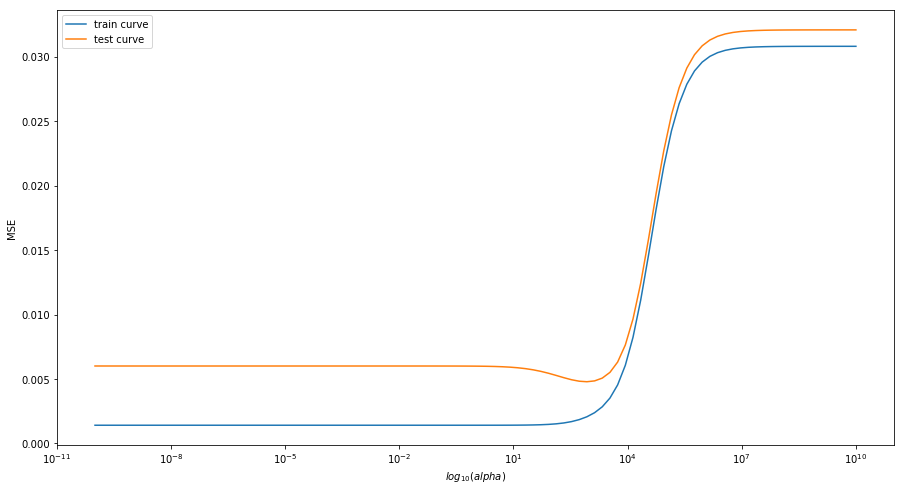

In [29]:
# Plot the validation curves
plt.figure(figsize=(15,8))
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()